In [1]:
!pip install pyro-ppl

     |████████████████████████████████| 686kB 8.5MB/s 


# examples

In [ ]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 2000

assert pyro.__version__.startswith('1.6.0')

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(6):
    data.append(torch.tensor(1.0))
for _ in range(4):
    data.append(torch.tensor(0.0))

def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the bernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

def guide(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))

AssertionError: ignored

In [ ]:
import os
import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
# Pyro also has a reparameterized Beta distribution so we import
# the non-reparameterized version to make our point
from pyro.distributions.testing.fakes import NonreparameterizedBeta
import pyro.optim as optim
from pyro.infer import SVI, TraceGraph_ELBO
import sys

assert pyro.__version__.startswith('1.7.0')

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
max_steps = 2 if smoke_test else 10000


def param_abs_error(name, target):
    return torch.sum(torch.abs(target - pyro.param(name))).item()


class BernoulliBetaExample:
    def __init__(self, max_steps):
        # the maximum number of inference steps we do
        self.max_steps = max_steps
        # the two hyperparameters for the beta prior
        self.alpha0 = 10.0
        self.beta0 = 10.0
        # the dataset consists of six 1s and four 0s
        self.data = torch.zeros(10)
        self.data[0:6] = torch.ones(6)
        self.n_data = self.data.size(0)
        # compute the alpha parameter of the exact beta posterior
        self.alpha_n = self.data.sum() + self.alpha0
        # compute the beta parameter of the exact beta posterior
        self.beta_n = - self.data.sum() + torch.tensor(self.beta0 + self.n_data)
        # initial values of the two variational parameters
        self.alpha_q_0 = 15.0
        self.beta_q_0 = 15.0

    def model(self, use_decaying_avg_baseline):
        # sample `latent_fairness` from the beta prior
        f = pyro.sample("latent_fairness", dist.Beta(self.alpha0, self.beta0))
        # use plate to indicate that the observations are
        # conditionally independent given f and get vectorization
        with pyro.plate("data_plate"):
            # observe all ten datapoints using the bernoulli likelihood
            pyro.sample("obs", dist.Bernoulli(f), obs=self.data)

    def guide(self, use_decaying_avg_baseline):
        # register the two variational parameters with pyro
        alpha_q = pyro.param("alpha_q", torch.tensor(self.alpha_q_0),
                             constraint=constraints.positive)
        beta_q = pyro.param("beta_q", torch.tensor(self.beta_q_0),
                            constraint=constraints.positive)
        # sample f from the beta variational distribution
        baseline_dict = {'use_decaying_avg_baseline': use_decaying_avg_baseline,
                         'baseline_beta': 0.90}
        # note that the baseline_dict specifies whether we're using
        # decaying average baselines or not
        pyro.sample("latent_fairness", NonreparameterizedBeta(alpha_q, beta_q),
                    infer=dict(baseline=baseline_dict))

    def do_inference(self, use_decaying_avg_baseline, tolerance=0.80):
        # clear the param store in case we're in a REPL
        pyro.clear_param_store()
        # setup the optimizer and the inference algorithm
        optimizer = optim.Adam({"lr": .0005, "betas": (0.93, 0.999)})
        svi = SVI(self.model, self.guide, optimizer, loss=TraceGraph_ELBO())
        print("Doing inference with use_decaying_avg_baseline=%s" % use_decaying_avg_baseline)

        # do up to this many steps of inference
        for k in range(self.max_steps):
            svi.step(use_decaying_avg_baseline)
            if k % 100 == 0:
                print('.', end='')
                sys.stdout.flush()

            # compute the distance to the parameters of the true posterior
            alpha_error = param_abs_error("alpha_q", self.alpha_n)
            beta_error = param_abs_error("beta_q", self.beta_n)

            # stop inference early if we're close to the true posterior
            if alpha_error < tolerance and beta_error < tolerance:
                break

        print("\nDid %d steps of inference." % k)
        print(("Final absolute errors for the two variational parameters " +
               "were %.4f & %.4f") % (alpha_error, beta_error))

# do the experiment
bbe = BernoulliBetaExample(max_steps=max_steps)
bbe.do_inference(use_decaying_avg_baseline=True)
bbe.do_inference(use_decaying_avg_baseline=False)

Doing inference with use_decaying_avg_baseline=True
...
Did 223 steps of inference.
Final absolute errors for the two variational parameters were 0.7253 & 0.8000
Doing inference with use_decaying_avg_baseline=False
.............
Did 1231 steps of inference.
Final absolute errors for the two variational parameters were 0.7996 & 0.7907


# Bayesian Regression

In [ ]:
%reset -s -f

In [ ]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.7.0')
pyro.set_rng_seed(1)

#set matplotlib setting
plt.style.use('default')

In [ ]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [ ]:
df.head()

,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


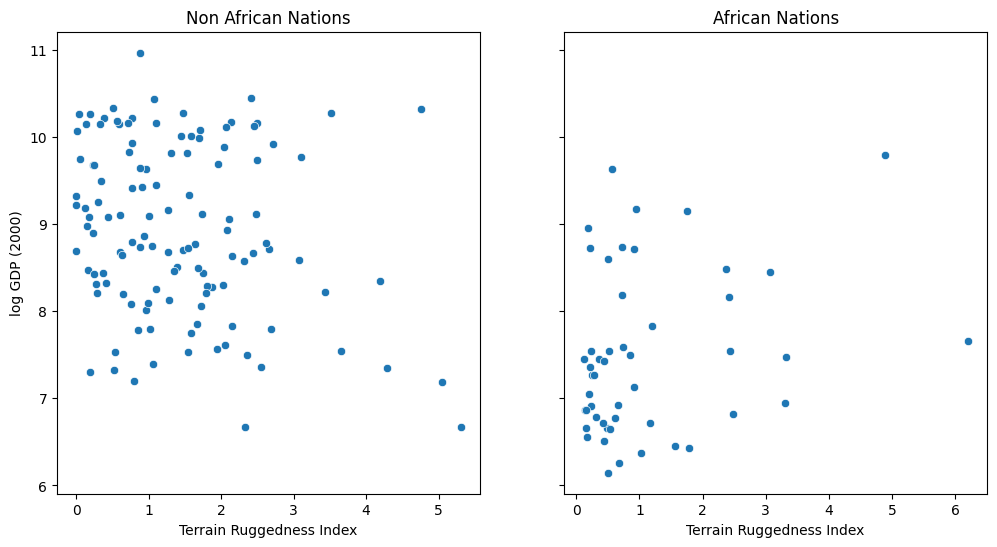

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            non_african_nations["rgdppc_2000"],
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
                african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");


In [ ]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [ ]:
# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

# Regression model
linear_reg_model = PyroModule[nn.Linear](3, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 3179.7847
[iteration 0100] loss: 1616.1371
[iteration 0150] loss: 1109.4115
[iteration 0200] loss: 833.7546
[iteration 0250] loss: 637.5823
[iteration 0300] loss: 488.2653
[iteration 0350] loss: 376.4651
[iteration 0400] loss: 296.0484
[iteration 0450] loss: 240.6140
[iteration 0500] loss: 203.9386
[iteration 0550] loss: 180.6171
[iteration 0600] loss: 166.3493
[iteration 0650] loss: 157.9457
[iteration 0700] loss: 153.1786
[iteration 0750] loss: 150.5735
[iteration 0800] loss: 149.2020
[iteration 0850] loss: 148.5065
[iteration 0900] loss: 148.1668
[iteration 0950] loss: 148.0070
[iteration 1000] loss: 147.9347
[iteration 1050] loss: 147.9032
[iteration 1100] loss: 147.8900
[iteration 1150] loss: 147.8847
[iteration 1200] loss: 147.8827
[iteration 1250] loss: 147.8819
[iteration 1300] loss: 147.8817
[iteration 1350] loss: 147.8816
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
Learned parameters:
weight [[-1.94785

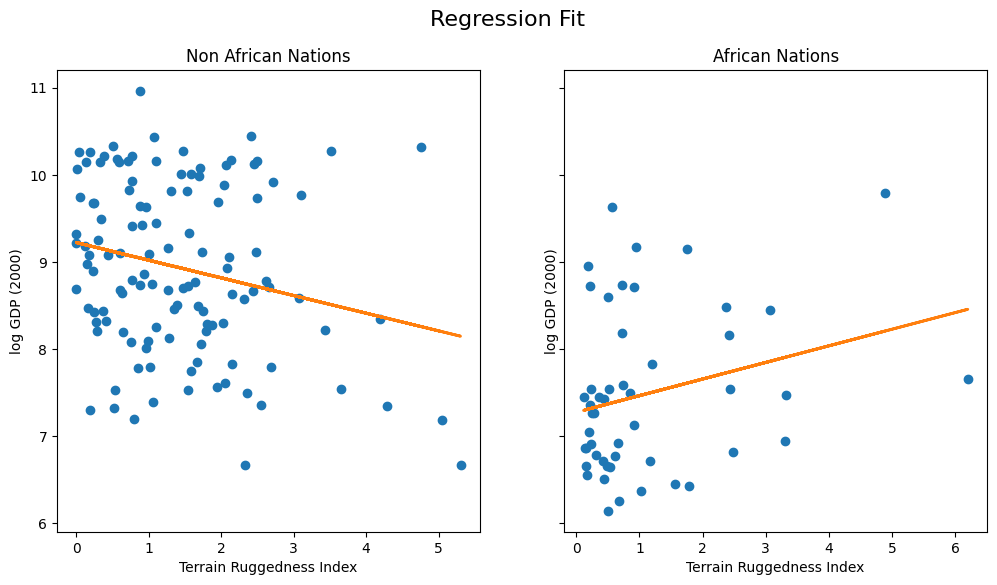

In [ ]:
fit = df.copy()
fit['mean'] = linear_reg_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1,ncols=2,figsize= (12,6), sharey = True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize = 16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"],"o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"],linewidth = 2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [ ]:
from pyro.nn import PyroSample


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [ ]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

In [ ]:
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [ ]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 6.2310
[iteration 0101] loss: 3.5269
[iteration 0201] loss: 3.2377
[iteration 0301] loss: 3.0867
[iteration 0401] loss: 2.6374
[iteration 0501] loss: 2.0617
[iteration 0601] loss: 1.4856
[iteration 0701] loss: 1.4631
[iteration 0801] loss: 1.4632
[iteration 0901] loss: 1.4592
[iteration 1001] loss: 1.4939
[iteration 1101] loss: 1.4989
[iteration 1201] loss: 1.4937
[iteration 1301] loss: 1.4679
[iteration 1401] loss: 1.4581


In [ ]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2371, -1.8097, -0.1691,  0.3790,  9.1824])
AutoDiagonalNormal.scale tensor([0.0552, 0.1143, 0.0387, 0.0769, 0.0700])


In [ ]:
guide.quantiles([0.25, 0.5, 0.75])

{'linear.bias': tensor([[9.1351],
         [9.1824],
         [9.2296]]), 'linear.weight': tensor([[[-1.8868, -0.1952,  0.3272]],
 
         [[-1.8097, -0.1691,  0.3790]],
 
         [[-1.7325, -0.1430,  0.4309]]]), 'sigma': tensor([0.9327, 0.9647, 0.9976])}

In [ ]:
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        print("v",v)
        print("k",k)
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

v tensor([[[[-1.9329, -0.1825,  0.2462]]],


        [[[-2.0556, -0.1823,  0.4028]]],


        [[[-1.9188, -0.1547,  0.3439]]],


        ...,


        [[[-1.6174, -0.1584,  0.2641]]],


        [[[-1.7088, -0.0954,  0.2760]]],


        [[[-1.7608, -0.0828,  0.4546]]]])
k linear.weight
v tensor([[ 6.8664,  8.0137,  9.2029,  ...,  8.6693,  6.6392,  8.2440],
        [ 7.4147,  7.4015,  7.3383,  ...,  7.1233,  6.5483,  7.5624],
        [ 8.9456,  8.8368, 11.0099,  ...,  7.0369,  7.5096,  7.9509],
        ...,
        [ 6.4828,  8.7560, 10.4798,  ...,  5.2664,  7.2680,  8.5931],
        [ 8.4794,  7.9002,  9.6009,  ...,  8.4459,  9.0184,  7.4327],
        [ 7.0591,  8.6282,  9.6028,  ...,  8.5921,  5.1684,  9.3607]])
k obs
v tensor([[7.3200, 8.5728, 9.0579,  ..., 7.3776, 7.2993, 7.3415],
        [7.1723, 8.4140, 8.8985,  ..., 7.3714, 7.1006, 7.2464],
        [7.5510, 8.7774, 9.1886,  ..., 7.7219, 7.4896, 7.6146],
        ...,
        [7.5841, 8.5677, 8.9889,  ..., 7.6795, 7.5497, 7.6196

In [ ]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

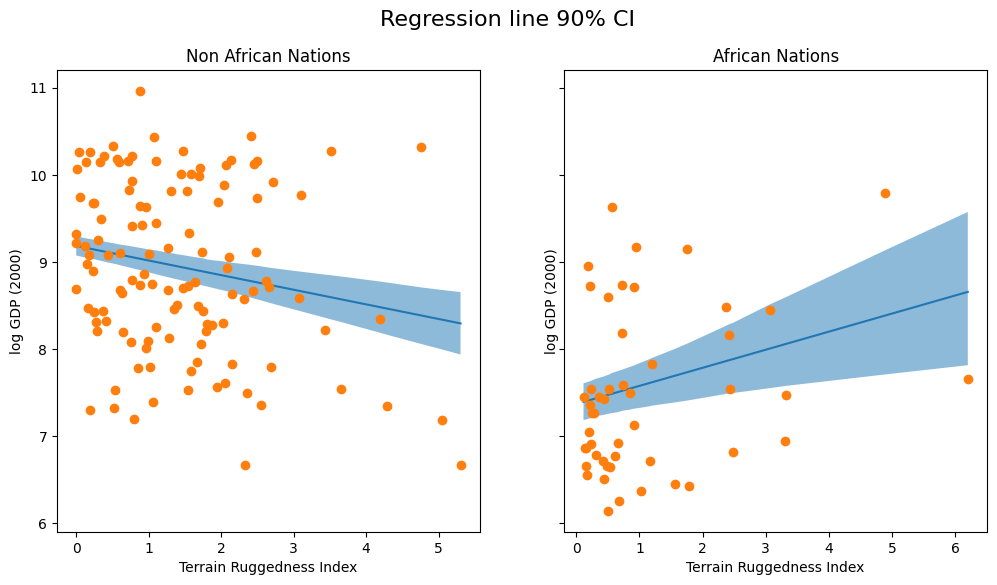

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

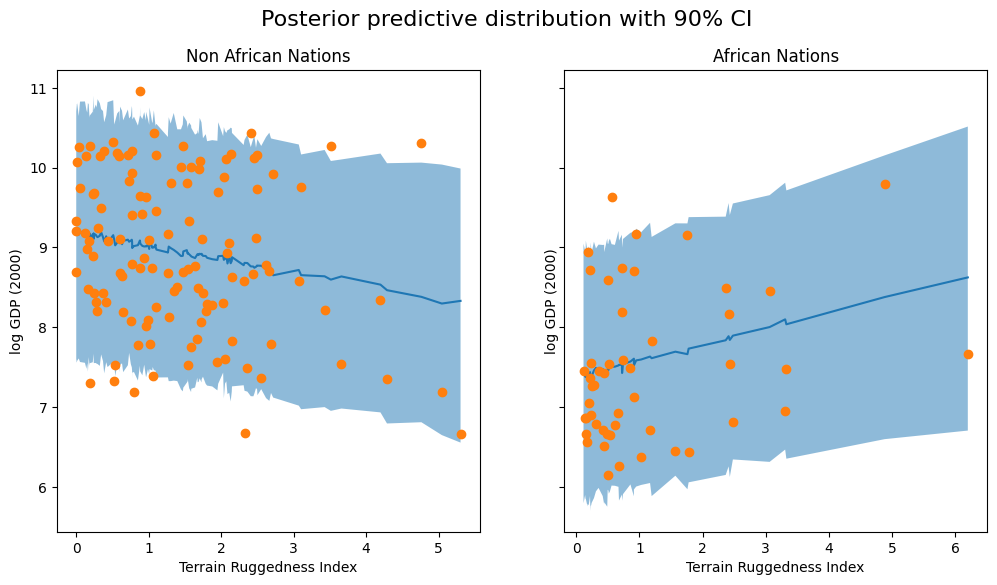

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


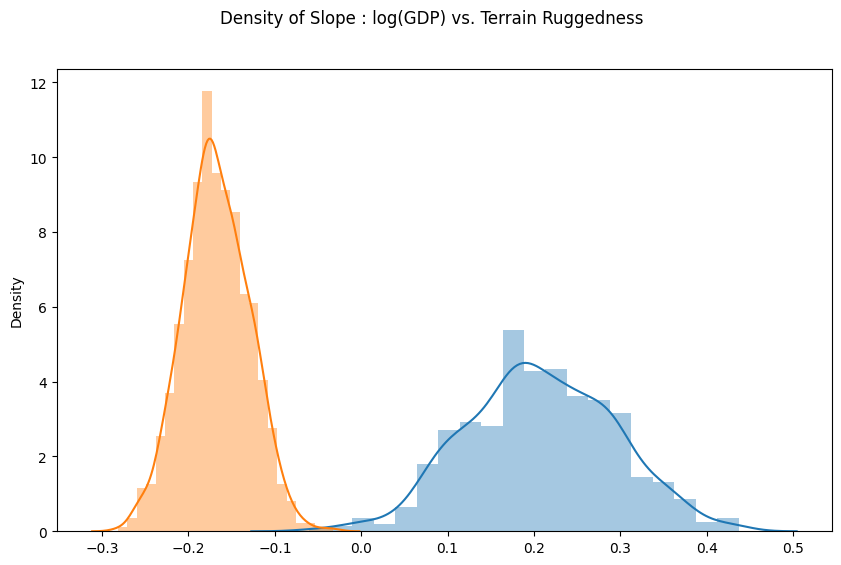

In [ ]:
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

In [ ]:
from collections import defaultdict
from pyro import poutine
from pyro.poutine.util import prune_subsample_sites
import warnings


class Predict(torch.nn.Module):
    def __init__(self, model, guide):
        super().__init__()
        self.model = model
        self.guide = guide

    def forward(self, *args, **kwargs):
        samples = {}
        guide_trace = poutine.trace(self.guide).get_trace(*args, **kwargs)
        model_trace = poutine.trace(poutine.replay(self.model, guide_trace)).get_trace(*args, **kwargs)
        for site in prune_subsample_sites(model_trace).stochastic_nodes:
            samples[site] = model_trace.nodes[site]['value']
        return tuple(v for _, v in sorted(samples.items()))

predict_fn = Predict(model, guide)
predict_module = torch.jit.trace_module(predict_fn, {"forward": (x_data,)}, check_trace=False)

In [ ]:
torch.jit.save(predict_module, '/tmp/reg_predict.pt')
pred_loaded = torch.jit.load('/tmp/reg_predict.pt')
pred_loaded(x_data)

(tensor([9.2164]),
 tensor([[-1.6610, -0.1498,  0.4282]]),
 tensor([ 7.5952,  8.2472,  9.3863,  9.2589,  9.0538,  9.3914,  8.6763,  9.3774,
          9.5471,  9.6144, 10.3520,  8.5453,  5.4010,  8.4600,  9.6217,  9.7772,
          7.1957,  7.2580,  8.9158,  9.0874,  8.3729,  8.7902,  9.3166,  8.8156,
          7.4434,  9.9980,  8.6907,  9.2914, 10.1375,  7.7619, 10.1916,  7.4755,
          6.3474,  7.7584,  9.1307,  6.0795,  8.5640,  7.8485,  9.2827,  9.0762,
          7.9251, 10.9224,  8.0004, 10.1797,  5.3612,  8.1173,  8.0586,  8.5098,
          6.8656,  8.6764,  7.8926,  9.5232, 10.1267, 10.2660,  7.8884,  8.9193,
         10.2864,  7.0823,  8.2370,  8.3088,  7.8409,  8.4892,  8.0106,  7.6814,
          8.7496,  9.3549,  9.9685, 10.4802,  8.5175,  7.1678, 10.8803,  7.4918,
          8.7087,  9.2416,  9.2359,  9.7906,  8.4933,  7.8896,  9.5337,  9.6571,
          9.6602,  9.9853,  6.7416,  8.1719, 10.0645, 10.0816,  8.4501,  9.2587,
          8.4487,  7.7514,  6.8496,  9.2207,  8.98

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


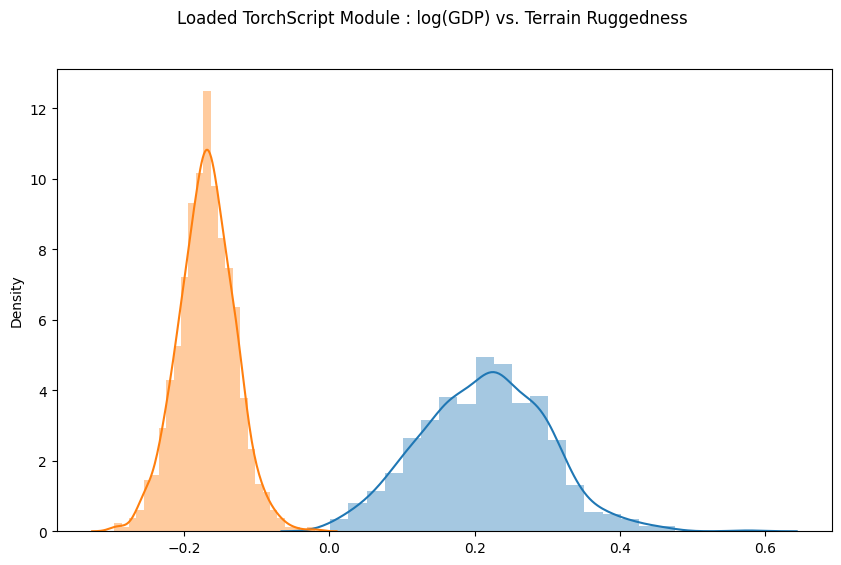

In [ ]:
weight = []
for _ in range(800):
    # index = 1 corresponds to "linear.weight"
    weight.append(pred_loaded(x_data)[1])
weight = torch.stack(weight).detach()
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Loaded TorchScript Module : log(GDP) vs. Terrain Ruggedness");

# Bayesian Regression - Inference Algorithms (Part 2)

In [ ]:
%reset -sf

In [ ]:
import logging
import os 
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
import pyro
import pyro.distributions as dist
import pyro.optim as optim

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.7.0')

In [ ]:
%matplotlib inline
plt.style.use('default')

logging.basicConfig(format='%(message)s', level = logging.INFO)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

In [ ]:
def model(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

def guide(is_cont_africa, ruggedness, log_gdp):
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', torch.randn(3))
    weights_scale = pyro.param('weights_scale', torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

In [ ]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

# Prepare training data
df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)

In [ ]:
from pyro.infer import SVI, Trace_ELBO


svi = SVI(model,
          guide,
          optim.Adam({"lr": .05}),
          loss=Trace_ELBO())

is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
num_iters = 5000 if not smoke_test else 2
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 5795.468078792095
Elbo loss: 415.81697630882263
Elbo loss: 250.71917808055878
Elbo loss: 247.19455885887146
Elbo loss: 249.2003738284111
Elbo loss: 250.9648449420929
Elbo loss: 249.350925385952
Elbo loss: 248.78312557935715
Elbo loss: 248.62143713235855
Elbo loss: 250.42745751142502


In [ ]:
from pyro.infer import Predictive


num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
               if k != "obs"}

In [ ]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
      mean       std       5%       25%       50%       75%      95%
0  9.17702  0.059607  9.07811  9.140463  9.178211  9.217098  9.27152 

Site: bA
       mean       std       5%       25%       50%       75%       95%
0 -1.890622  0.122805 -2.08849 -1.979107 -1.887476 -1.803683 -1.700853 

Site: bR
       mean       std       5%       25%       50%       75%       95%
0 -0.157847  0.039538 -0.22324 -0.183673 -0.157873 -0.133102 -0.091713 

Site: bAR
       mean       std        5%       25%       50%       75%       95%
0  0.304515  0.067683  0.194583  0.259464  0.304908  0.348932  0.415128 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.902898  0.047971  0.824166  0.870317  0.901982  0.935171  0.981577 



In [ ]:
from pyro.infer import MCMC, NUTS


nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(is_cont_africa, ruggedness, log_gdp)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 1200/1200 [00:30, 39.56it/s, step size=4.73e-01, acc. prob=0.920]


In [ ]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean      std        5%       25%       50%       75%       95%
0  9.179546  0.13631  8.948674  9.092796  9.182643  9.272237  9.384867 

Site: bA
       mean      std     5%       25%       50%       75%       95%
0 -1.832929  0.23524 -2.217 -1.983383 -1.837151 -1.681208 -1.441309 

Site: bAR
       mean       std        5%       25%       50%       75%      95%
0  0.342208  0.129034  0.126836  0.251245  0.343096  0.428025  0.55039 

Site: bR
       mean       std        5%       25%      50%       75%       95%
0 -0.182088  0.074199 -0.295771 -0.232334 -0.18379 -0.134868 -0.055269 

Site: sigma
       mean       std        5%       25%      50%       75%       95%
0  0.954808  0.054706  0.871808  0.916038  0.94973  0.989015  1.049073 



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

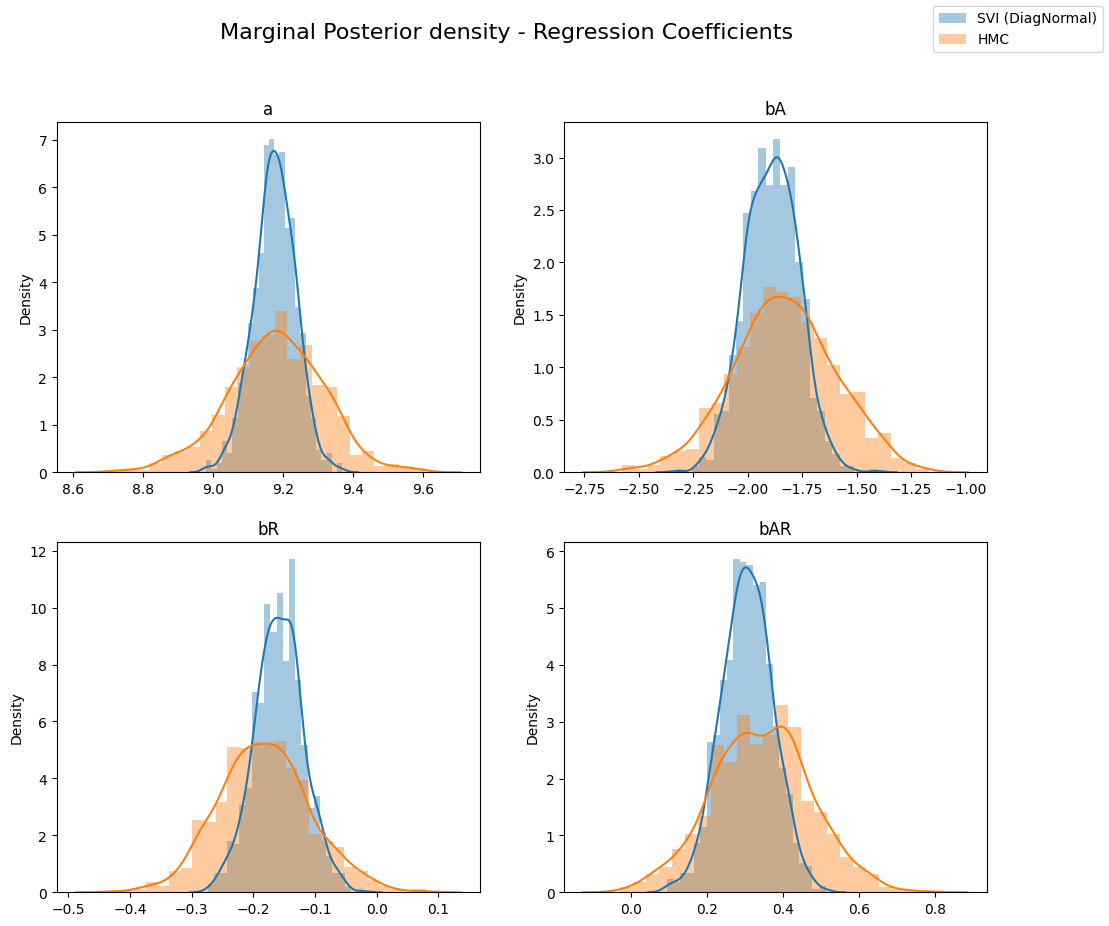

In [ ]:
sites = ["a", "bA", "bR", "bAR", "sigma"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(svi_samples[site], ax=ax, label="SVI (DiagNormal)")
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

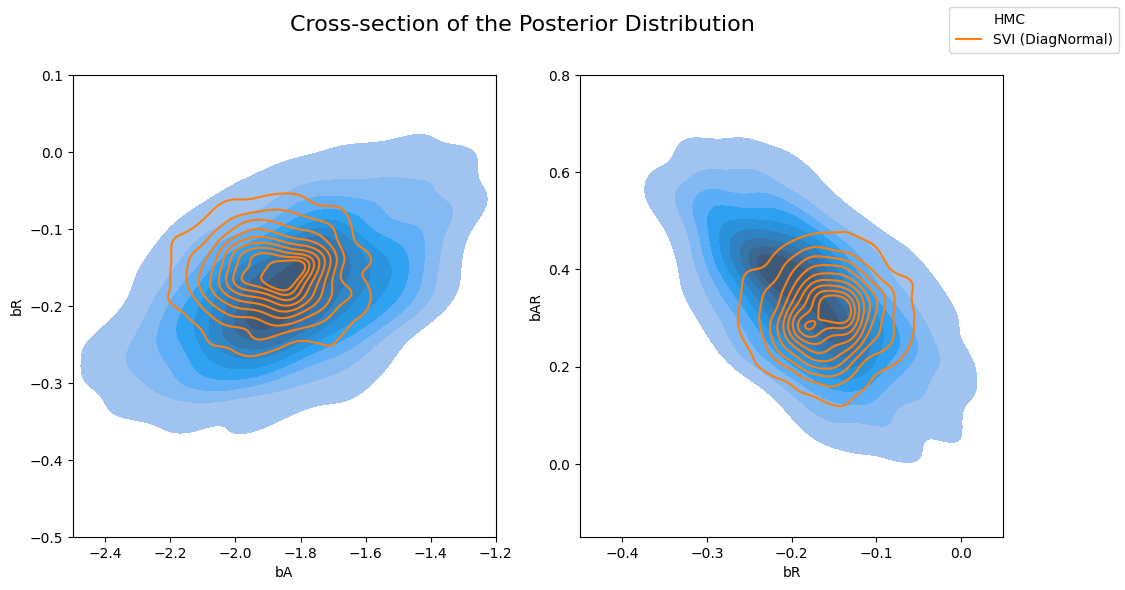

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(hmc_samples["bA"], hmc_samples["bR"], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(svi_samples["bA"], svi_samples["bR"], ax=axs[0], label="SVI (DiagNormal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(hmc_samples["bR"], hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(svi_samples["bR"], svi_samples["bAR"], ax=axs[1], label="SVI (DiagNormal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

In [ ]:
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean


guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

svi = SVI(model,
          guide,
          optim.Adam({"lr": .01}),
          loss=Trace_ELBO())

is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 703.2962011098862
Elbo loss: 420.50198435783386
Elbo loss: 250.7025689482689
Elbo loss: 249.8654989004135
Elbo loss: 249.30760949850082
Elbo loss: 247.30142492055893
Elbo loss: 249.7928325533867
Elbo loss: 247.20394849777222
Elbo loss: 248.54042530059814
Elbo loss: 249.66331708431244


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

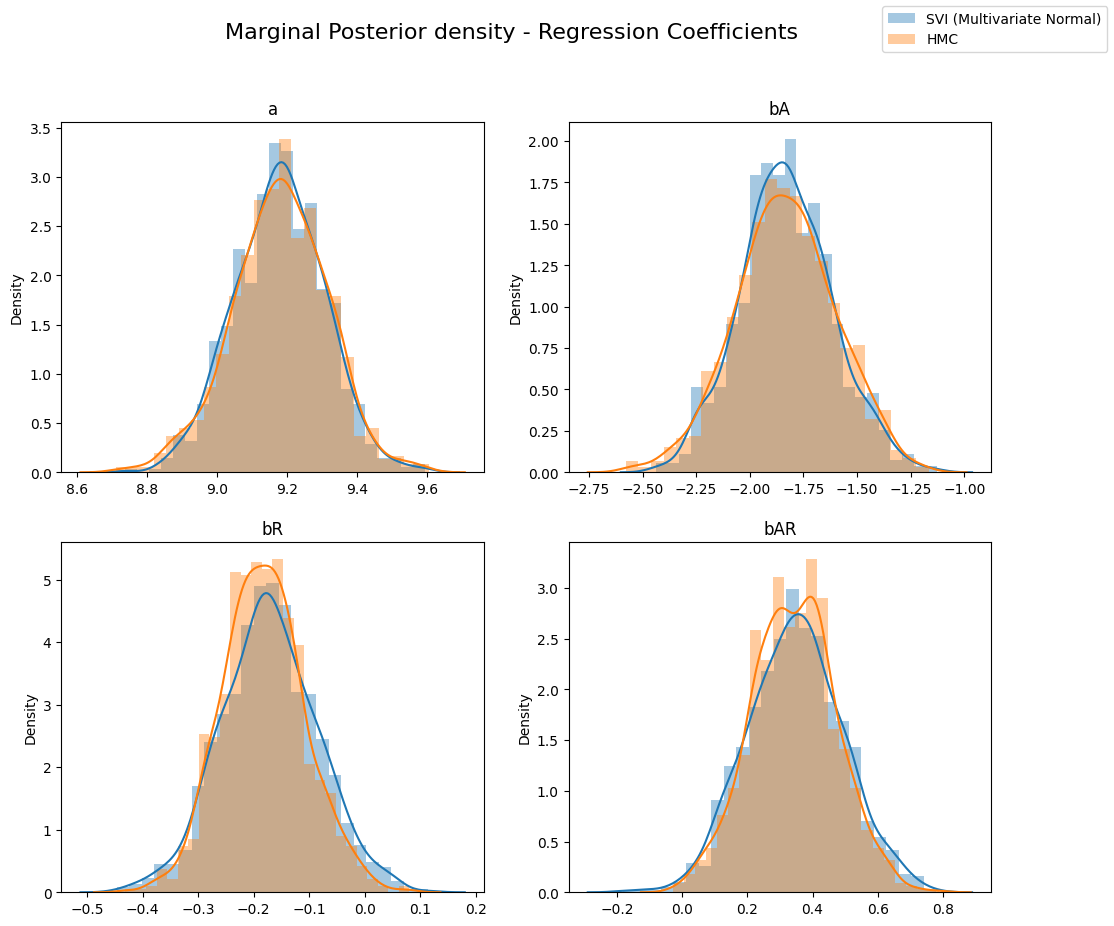

In [ ]:
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_mvn_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
                   for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
                   if k != "obs"}
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(svi_mvn_samples[site], ax=ax, label="SVI (Multivariate Normal)")
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

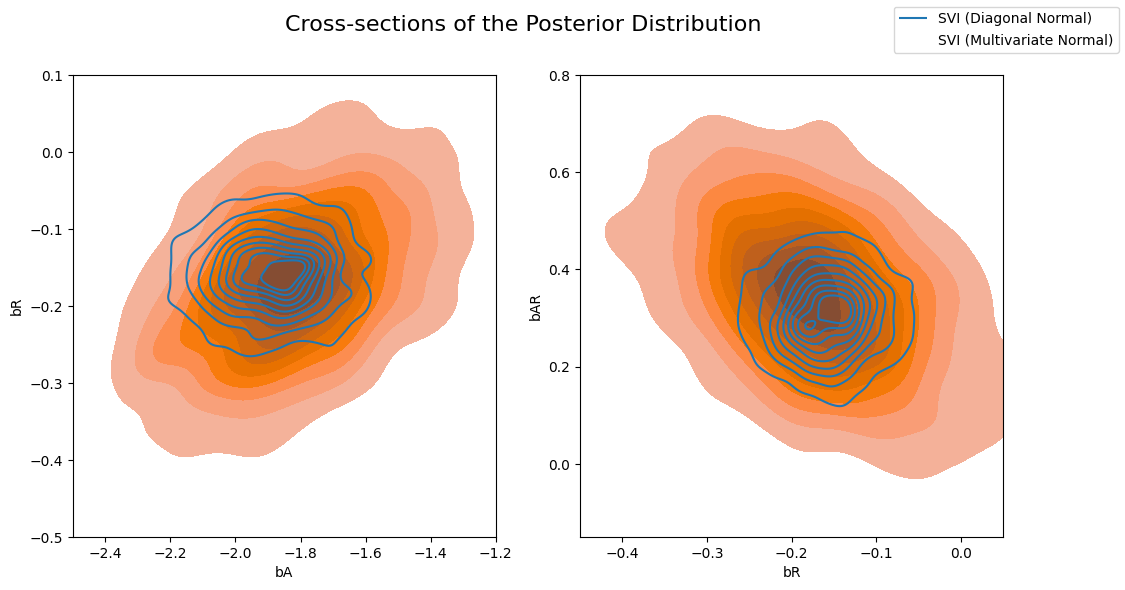

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(svi_samples["bA"], svi_samples["bR"], ax=axs[0], label="SVI (Diagonal Normal)")
sns.kdeplot(svi_mvn_samples["bA"], svi_mvn_samples["bR"], ax=axs[0], shade=True, label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(svi_samples["bR"], svi_samples["bAR"], ax=axs[1], label="SVI (Diagonal Normal)")
sns.kdeplot(svi_mvn_samples["bR"], svi_mvn_samples["bAR"], ax=axs[1], shade=True, label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

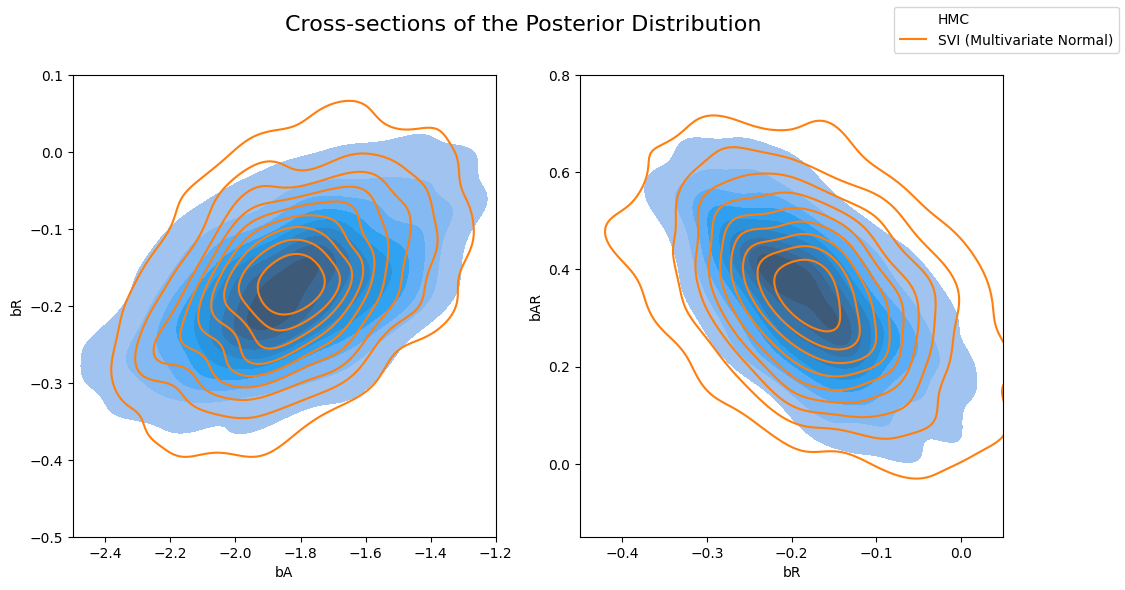

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(hmc_samples["bA"], hmc_samples["bR"], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(svi_mvn_samples["bA"], svi_mvn_samples["bR"], ax=axs[0], label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(hmc_samples["bR"], hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(svi_mvn_samples["bR"], svi_mvn_samples["bAR"], ax=axs[1], label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

# SIR

In [2]:
# Copyright Contributors to the Pyro project.
# SPDX-License-Identifier: Apache-2.0

# Introduction
# ============
#
# This advanced Pyro tutorial demonstrates a number of inference and prediction
# tricks in the context of epidemiological models, specifically stochastic
# discrete time compartmental models with large discrete state spaces. This
# tutorial assumes the reader has completed all introductory tutorials and
# additionally the tutorials on enumeration and effect handlers (poutines):
# http://pyro.ai/examples/enumeration.html
# http://pyro.ai/examples/effect_handlers.html

import argparse
import logging
import math
import re
from collections import OrderedDict

import torch

import pyro
import pyro.distributions as dist
import pyro.distributions.hmm
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS, config_enumerate, infer_discrete
from pyro.infer.autoguide import init_to_value
from pyro.ops.special import safe_log
from pyro.ops.tensor_utils import convolve
from pyro.util import warn_if_nan

logging.basicConfig(format="%(message)s", level=logging.INFO)

# A Discrete SIR Model
# ====================
#
# Let's consider one of the simplest compartmental models: an SIR model
# https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model
# This models the dynamics of three groups within a population:
#
#   population = Susceptible + Infected + Recovered
#
# At each discrete time step, each infected person infects a random number of
# susceptible people, and then randomly may recover. We noisily observe the
# number of people newly infected at each time step, assuming an unknown false
# negative rate, but no false positives. Our eventual objective is to estimate
# global model parameters R0 (the basic reproduction number), tau (the expected
# recovery time), and rho (the mean response rate = 1 - false negative rate).
# Having estimated these we will then estimate latent time series and forecast
# forward.
#
# We'll start by defining a discrete_model that uses a helper global_model to
# sample global parameters.
#
# Note we need to use ExtendedBinomial rather than Binomial because the data
# may lie outside of the predicted support. For these values,
# Binomial.log_prob() will error, whereas ExtendedBinomial.log_prob() will
# return -inf.

def global_model(population):
  tau = args.recovery_time # Assume this can be measured exactly.
  R0 = pyro.sample("R0", dist.LogNormal(0.0,1.0))
  rho = pyro.sample('rho', dist.Uniform(0,1))

  # Convert interpretable parameters to distribution parameters
  rate_s = -R0/(tau*population)
  prob_i = 1/(1 + tau)

  return rate_s, prob_i, rho

def discrete_model(args, data):
  # Sample global parameters
  rate_s, prob_i, rho = global_model(args.population)

  # Sequentially sample time-local variables.
  S = torch.tensor(args.population - 1.0)
  I = torch.tensor(1.0)
  for t, datum in enumerate(data):
    S2I = pyro.sample("S2I_{}".format(t), dist.Binomial(S, -(rate_s*I).expm1()))
    I2R = pyro.sample("I2R_{}".format(t), dist.Binomial(I, prob_i))
    S = pyro.deterministic("S_{}".format(t), S - S2I)
    I = pyro.deterministic("I_{}".format(t), I + S2I - I2R)
    pyro.sample("obs_{}".format(t), dist.ExtendedBinomial(S2I, rho), obs = datum)

# We can use this model to simulate data. We'll use poutine.condition to pin
# parameter values and poutine.trace to record sample observations.

def generate_data(args):
  logging.info("Generating data...")
  params = {
      "R0": torch.tensor(args.basic_reprodcution_number),
      "rho": torch
  }
  empty_data = [None]*(args.duration + args.forecast)

  # We'll retry until we get an actual outbreak.
  for attempt in range(100):
    with poutine.trace() as tr:
      with poutine.condition(data = params):
        discrete_model(args, empty_data)

    # concatenate sequential time series into tensors
    obs = torch.stack(
        [
         site["value"]
         for name, site in tr.trace.nodes.items()
         if re.match("obs_[0-9]+",name)
        ]
    )
    S2I = torch.stack(
        [
         site["value"]
         for name, site in tr.trace.nodes.items()
         if re.match("S2I_[0-9]+", name)
        ]
    )
    assert len(obs) == len(empty_data)

    obs_sum = int(obs[: args.duration].sum())
    S2I_sum = int(S2I[: args.duration].sum())
    if obs_sum >= args.min_observations:
      logging.info(
          "Observed {:d}/{:d} infection:\n{}".format(
              obs_sum,S2I_sum, " ".join([str(int(x)) for x in obs[: args.duration]]),
          )
      )
      return {"S2I": S2I, "obs": obs}
  raise ValueError(
      "Failed to generate {} observations. Try increasing "
      "--population or decreasing --min-observations".format(args.min_observations)
  )

# Inference
# =========
#
# While the above discrete_model is easy to understand, its discrete latent
# variables pose a challenge for inference. One of the most popular inference
# strategies for such models is Sequential Monte Carlo. However since Pyro and
# PyTorch are stronger in gradient based vectorizable inference algorithms, we
# will instead pursue inference based on Hamiltonian Monte Carlo (HMC).
#
# Our general inference strategy will be to:
# 1. Introduce auxiliary variables to make the model Markov.
# 2. Introduce more auxiliary variables to create a discrete parameterization.
# 3. Marginalize out all remaining discrete latent variables.
# 4. Vectorize to enable parallel-scan temporal filtering.
#
# Let's consider reparameterizing in terms of the variables (S, I) rather than
# (S2I, I2R). Since these may lead to inconsistent states, we need to replace
# the Binomial transition factors (S2I, I2R) with ExtendedBinomial.
#
# The following model is equivalent to the discrete_model:

@config_enumerate
def reparameterized_discrete_model(args, data):
  # sample global parameters
  rate_s, prob_i, rho = global_,model(args.population)

  # Sequentially sample time-local variables.
  S_curr = torch.tensor(args.population - 1.0)
  I_curr = torch.tensor(1.0)
  for t, datum in enumerate(data):
    # Sample reparameterizing variables.
    # When reparameterizing to a factor graph, we ignored density via
    # .mask(False). Thus distributions are used only for initialization.
    S_prev, I_prev = S_curr, I_curr
    S_curr = pyro.sample(
        "S_{}".format(t), dist.Binomial(args.population, 0.5).mask(False)
    )
    I_curr = pyro.sample(
        "I_{}".format(t), dist.Binomial(args.population, 0.5),mask(False)
    )

    # Now we reverse the computation.
    S2I = S_prev - S_curr
    I2R = I_prev - I_curr + S2I
    pyro.sample(
        "S2I_{}".format(t),
        dist.ExtendedBinomial(S_prev, -(rate_s * I__prev).expm1()),
        obs = S2I,
    )
    pyro.sample("I2R_{}".format(t), dist.ExtendedBinomial(I_prev, prob_i), obs = I2R)
    pyro.sample("obs_{}".format(t), dist.ExtendedBinomial(S2I, rho), obs = datum)

# By reparameterizing, we have converted to coordinates that make the model
# Markov. We have also replaced dynamic integer_interval constraints with
# easier static integer_interval constraints (although we'll still need good
# initialization to avoid NANs). Since the discrete latent variables are
# bounded (by population size), we can enumerate out discrete latent variables
# and perform HMC inference over the global latents. However enumeration
# complexity is O(population^4), so this is only feasible for very small
# populations.
#
# Here is an inference approach using an MCMC sampler.

def infer_hmc_enum(args, data):
  model = reparameterized_discrete_model
  return _infer_hmc(args, data, model)

def _infer_hmc(args, data, model, init_values={}):
    logging.info("Running inference...")
    kernel = NUTS(
        model,
        full_mass=[("R0", "rho")],
        max_tree_depth=args.max_tree_depth,
        init_strategy=init_to_value(values=init_values),
        jit_compile=args.jit,
        ignore_jit_warnings=True,
    )

    # We'll define a hook_fn to log potential energy values during inference.
    # This is helpful to diagnose whether the chain is mixing.
    energies = []

    def hook_fn(kernel, *unused):
        e = float(kernel._potential_energy_last)
        energies.append(e)
        if args.verbose:
            logging.info("potential = {:0.6g}".format(e))

    mcmc = MCMC(
        kernel,
        hook_fn=hook_fn,
        num_samples=args.num_samples,
        warmup_steps=args.warmup_steps,
    )
    mcmc.run(args, data)
    mcmc.summary()
    if args.plot:
        import matplotlib.pyplot as plt

        plt.figure(figsize=(6, 3))
        plt.plot(energies)
        plt.xlabel("MCMC step")
        plt.ylabel("potential energy")
        plt.title("MCMC energy trace")
        plt.tight_layout()

    samples = mcmc.get_samples()
    return samples


# To scale to large populations, we'll continue to reparameterize, this time
# replacing each of (S_aux,I_aux) with a combination of a bounded real
# variable and a Categorical variable with only four values.
#
# This is the crux: we can now perform HMC over the real variable and
# marginalize out the Categorical variables using variable elimination.
#
# We first define a helper to create enumerated Categorical sites.


def quantize(name, x_real, min, max):
    """
    Randomly quantize in a way that preserves probability mass.
    We use a piecewise polynomial spline of order 3.
    """
    assert min < max
    lb = x_real.detach().floor()

    # This cubic spline interpolates over the nearest four integers, ensuring
    # piecewise quadratic gradients.
    s = x_real - lb
    ss = s * s
    t = 1 - s
    tt = t * t
    probs = (
        torch.stack(
            [
                t * tt,
                4 + ss * (3 * s - 6),
                4 + tt * (3 * t - 6),
                s * ss,
            ],
            dim=-1,
        )
        * (1 / 6)
    )
    q = pyro.sample("Q_" + name, dist.Categorical(probs)).type_as(x_real)

    x = lb + q - 1
    x = torch.max(x, 2 * min - 1 - x)
    x = torch.min(x, 2 * max + 1 - x)

    return pyro.deterministic(name, x)


# Now we can define another equivalent model.


@config_enumerate
def continuous_model(args, data):
    # Sample global parameters.
    rate_s, prob_i, rho = global_model(args.population)

    # Sample reparameterizing variables.
    S_aux = pyro.sample(
        "S_aux",
        dist.Uniform(-0.5, args.population + 0.5)
        .mask(False)
        .expand(data.shape)
        .to_event(1),
    )
    I_aux = pyro.sample(
        "I_aux",
        dist.Uniform(-0.5, args.population + 0.5)
        .mask(False)
        .expand(data.shape)
        .to_event(1),
    )

    # Sequentially sample time-local variables.
    S_curr = torch.tensor(args.population - 1.0)
    I_curr = torch.tensor(1.0)
    for t, datum in poutine.markov(enumerate(data)):
        S_prev, I_prev = S_curr, I_curr
        S_curr = quantize("S_{}".format(t), S_aux[..., t], min=0, max=args.population)
        I_curr = quantize("I_{}".format(t), I_aux[..., t], min=0, max=args.population)

        # Now we reverse the computation.
        S2I = S_prev - S_curr
        I2R = I_prev - I_curr + S2I
        pyro.sample(
            "S2I_{}".format(t),
            dist.ExtendedBinomial(S_prev, -(rate_s * I_prev).expm1()),
            obs=S2I,
        )
        pyro.sample("I2R_{}".format(t), dist.ExtendedBinomial(I_prev, prob_i), obs=I2R)
        pyro.sample("obs_{}".format(t), dist.ExtendedBinomial(S2I, rho), obs=datum)


# Now all latent variables in the continuous_model are either continuous or
# enumerated, so we can use HMC. However we need to take special care with
# constraints because the above Markov reparameterization covers regions of
# hypothesis space that are infeasible (i.e. whose log_prob is -infinity). We
# thus heuristically initialize to a feasible point.


def heuristic_init(args, data):
    """Heuristically initialize to a feasible point."""
    # Start with a single infection.
    S0 = args.population - 1
    # Assume 50% <= response rate <= 100%.
    S2I = data * min(2.0, (S0 / data.sum()).sqrt())
    S_aux = (S0 - S2I.cumsum(-1)).clamp(min=0.5)
    # Account for the single initial infection.
    S2I[0] += 1
    # Assume infection lasts less than a month.
    recovery = torch.arange(30.0).div(args.recovery_time).neg().exp()
    I_aux = convolve(S2I, recovery)[: len(data)].clamp(min=0.5)

    return {
        "R0": torch.tensor(2.0),
        "rho": torch.tensor(0.5),
        "S_aux": S_aux,
        "I_aux": I_aux,
    }


def infer_hmc_cont(model, args, data):
    init_values = heuristic_init(args, data)
    return _infer_hmc(args, data, model, init_values=init_values)


# Our final inference trick is to vectorize. We can repurpose DiscreteHMM's
# implementation here, but we'll need to manually represent a Markov
# neighborhood of multiple Categorical of size 4 as single joint Categorical
# with 4 * 4 = 16 states, and then manually perform variable elimination (the
# factors here don't quite conform to DiscreteHMM's interface).


def quantize_enumerate(x_real, min, max):
    """
    Randomly quantize in a way that preserves probability mass.
    We use a piecewise polynomial spline of order 3.
    """
    assert min < max
    lb = x_real.detach().floor()

    # This cubic spline interpolates over the nearest four integers, ensuring
    # piecewise quadratic gradients.
    s = x_real - lb
    ss = s * s
    t = 1 - s
    tt = t * t
    probs = (
        torch.stack(
            [
                t * tt,
                4 + ss * (3 * s - 6),
                4 + tt * (3 * t - 6),
                s * ss,
            ],
            dim=-1,
        )
        * (1 / 6)
    )
    logits = safe_log(probs)
    q = torch.arange(-1.0, 3.0)

    x = lb.unsqueeze(-1) + q
    x = torch.max(x, 2 * min - 1 - x)
    x = torch.min(x, 2 * max + 1 - x)
    return x, logits


def vectorized_model(args, data):
    # Sample global parameters.
    rate_s, prob_i, rho = global_model(args.population)

    # Sample reparameterizing variables.
    S_aux = pyro.sample(
        "S_aux",
        dist.Uniform(-0.5, args.population + 0.5)
        .mask(False)
        .expand(data.shape)
        .to_event(1),
    )
    I_aux = pyro.sample(
        "I_aux",
        dist.Uniform(-0.5, args.population + 0.5)
        .mask(False)
        .expand(data.shape)
        .to_event(1),
    )

    # Manually enumerate.
    S_curr, S_logp = quantize_enumerate(S_aux, min=0, max=args.population)
    I_curr, I_logp = quantize_enumerate(I_aux, min=0, max=args.population)
    # Truncate final value from the right then pad initial value onto the left.
    S_prev = torch.nn.functional.pad(
        S_curr[:-1], (0, 0, 1, 0), value=args.population - 1
    )
    I_prev = torch.nn.functional.pad(I_curr[:-1], (0, 0, 1, 0), value=1)
    # Reshape to support broadcasting, similar to EnumMessenger.
    T = len(data)
    Q = 4
    S_prev = S_prev.reshape(T, Q, 1, 1, 1)
    I_prev = I_prev.reshape(T, 1, Q, 1, 1)
    S_curr = S_curr.reshape(T, 1, 1, Q, 1)
    S_logp = S_logp.reshape(T, 1, 1, Q, 1)
    I_curr = I_curr.reshape(T, 1, 1, 1, Q)
    I_logp = I_logp.reshape(T, 1, 1, 1, Q)
    data = data.reshape(T, 1, 1, 1, 1)

    # Reverse the S2I,I2R computation.
    S2I = S_prev - S_curr
    I2R = I_prev - I_curr + S2I

    # Compute probability factors.
    S2I_logp = dist.ExtendedBinomial(S_prev, -(rate_s * I_prev).expm1()).log_prob(S2I)
    I2R_logp = dist.ExtendedBinomial(I_prev, prob_i).log_prob(I2R)
    obs_logp = dist.ExtendedBinomial(S2I, rho).log_prob(data)

    # Manually perform variable elimination.
    logp = S_logp + (I_logp + obs_logp) + S2I_logp + I2R_logp
    logp = logp.reshape(-1, Q * Q, Q * Q)
    logp = pyro.distributions.hmm._sequential_logmatmulexp(logp)
    logp = logp.reshape(-1).logsumexp(0)
    logp = logp - math.log(4)  # Account for S,I initial distributions.
    warn_if_nan(logp)
    pyro.factor("obs", logp)


# We can fit vectorized_model exactly as we fit the original continuous_model,
# using our infer_hmc_cont helper. The vectorized model is more than an order
# of magnitude faster than the sequential version, and scales logarithmically
# in time (up to your machine's parallelism).
#
# After inference we have samples of all latent variables. Let's define a
# helper to examine the inferred posterior distributions.


def evaluate(args, samples):
    # Print estimated values.
    names = {"basic_reproduction_number": "R0", "response_rate": "rho"}
    for name, key in names.items():
        mean = samples[key].mean().item()
        std = samples[key].std().item()
        logging.info(
            "{}: truth = {:0.3g}, estimate = {:0.3g} \u00B1 {:0.3g}".format(
                key, getattr(args, name), mean, std
            )
        )

    # Optionally plot histograms.
    if args.plot:
        import matplotlib.pyplot as plt
        import seaborn as sns

        fig, axes = plt.subplots(2, 1, figsize=(5, 5))
        axes[0].set_title("Posterior parameter estimates")
        for ax, (name, key) in zip(axes, names.items()):
            truth = getattr(args, name)
            sns.distplot(samples[key], ax=ax, label="posterior")
            ax.axvline(truth, color="k", label="truth")
            ax.set_xlabel(key + " = " + name.replace("_", " "))
            ax.set_yticks(())
            ax.legend(loc="best")
        plt.tight_layout()


# Prediction and Forecasting
# ==========================
#
# So far we've written four models that each describe the same probability
# distribution. Each successive model made inference cheaper. Next let's move
# beyond inference and consider predicting latent infection rate and
# forecasting future infections.
#
# We'll use Pyro's effect handlers to combine multiple of the above models,
# leveraging the vectorized_model for inference, then the continuous_model to
# compute local latent variables, and finally the original discrete_model to
# forecast forward in time. Let's assume posterior samples have already been
# generated via infer_hmc_cont(vectorized_model, ...).


@torch.no_grad()
def predict(args, data, samples, truth=None):
    logging.info("Forecasting {} steps ahead...".format(args.forecast))
    particle_plate = pyro.plate("particles", args.num_samples, dim=-1)

    # First we sample discrete auxiliary variables from the continuous
    # variables sampled in vectorized_model. This samples only time steps
    # [0:duration]. Here infer_discrete runs a forward-filter backward-sample
    # algorithm. We'll add these new samples to the existing dict of samples.
    model = poutine.condition(continuous_model, samples)
    model = particle_plate(model)
    model = infer_discrete(model, first_available_dim=-2)
    with poutine.trace() as tr:
        model(args, data)
    samples = OrderedDict(
        (name, site["value"])
        for name, site in tr.trace.nodes.items()
        if site["type"] == "sample"
    )

    # Next we'll run the forward generative process in discrete_model. This
    # samples time steps [duration:duration+forecast]. Again we'll update the
    # dict of samples.
    extended_data = list(data) + [None] * args.forecast
    model = poutine.condition(discrete_model, samples)
    model = particle_plate(model)
    with poutine.trace() as tr:
        model(args, extended_data)
    samples = OrderedDict(
        (name, site["value"])
        for name, site in tr.trace.nodes.items()
        if site["type"] == "sample"
    )

    # Finally we'll concatenate the sequentially sampled values into contiguous
    # tensors. This operates on the entire time interval [0:duration+forecast].
    for key in ("S", "I", "S2I", "I2R"):
        pattern = key + "_[0-9]+"
        series = [value for name, value in samples.items() if re.match(pattern, name)]
        assert len(series) == args.duration + args.forecast
        series[0] = series[0].expand(series[1].shape)
        samples[key] = torch.stack(series, dim=-1)
    S2I = samples["S2I"]
    median = S2I.median(dim=0).values
    logging.info(
        "Median prediction of new infections (starting on day 0):\n{}".format(
            " ".join(map(str, map(int, median)))
        )
    )

    # Optionally plot the latent and forecasted series of new infections.
    if args.plot:
        import matplotlib.pyplot as plt

        plt.figure()
        time = torch.arange(args.duration + args.forecast)
        p05 = S2I.kthvalue(int(round(0.5 + 0.05 * args.num_samples)), dim=0).values
        p95 = S2I.kthvalue(int(round(0.5 + 0.95 * args.num_samples)), dim=0).values
        plt.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
        plt.plot(time, median, "r-", label="median")
        plt.plot(time[: args.duration], data, "k.", label="observed")
        if truth is not None:
            plt.plot(time, truth, "k--", label="truth")
        plt.axvline(args.duration - 0.5, color="gray", lw=1)
        plt.xlim(0, len(time) - 1)
        plt.ylim(0, None)
        plt.xlabel("day after first infection")
        plt.ylabel("new infections per day")
        plt.title("New infections in population of {}".format(args.population))
        plt.legend(loc="upper left")
        plt.tight_layout()

    return samples


# Experiments
# ===========
#
# Finally we'll define an experiment runner. For example we can simulate 60
# days of infection on a population of 10000 and forecast forward another 30
# days, and plot the results as follows (takes about 3 minutes on my laptop):
#
# python sir_hmc.py -p 10000 -d 60 -f 30 --plot


def main(args):
    pyro.set_rng_seed(args.rng_seed)

    dataset = generate_data(args)
    obs = dataset["obs"][: args.duration]

    # Choose among inference methods.
    if args.enum:
        samples = infer_hmc_enum(args, obs)
    elif args.sequential:
        samples = infer_hmc_cont(continuous_model, args, obs)
    else:
        samples = infer_hmc_cont(vectorized_model, args, obs)

    # Evaluate fit.
    evaluate(args, samples)

    # Predict latent time series.
    if args.forecast:
        samples = predict(args, obs, samples, truth=dataset["S2I"])

    return samples


if __name__ == "__main__":
    assert pyro.__version__.startswith("1.7.0")
    parser = argparse.ArgumentParser(description="SIR epidemiology modeling using HMC")
    parser.add_argument("-p", "--population", default=10, type=int)
    parser.add_argument("-m", "--min-observations", default=3, type=int)
    parser.add_argument("-d", "--duration", default=10, type=int)
    parser.add_argument("-f", "--forecast", default=0, type=int)
    parser.add_argument("-R0", "--basic-reproduction-number", default=1.5, type=float)
    parser.add_argument("-tau", "--recovery-time", default=7.0, type=float)
    parser.add_argument("-rho", "--response-rate", default=0.5, type=float)
    parser.add_argument(
        "-e", "--enum", action="store_true", help="use the full enumeration model"
    )
    parser.add_argument(
        "-s",
        "--sequential",
        action="store_true",
        help="use the sequential continuous model",
    )
    parser.add_argument("-n", "--num-samples", default=200, type=int)
    parser.add_argument("-w", "--warmup-steps", default=100, type=int)
    parser.add_argument("-t", "--max-tree-depth", default=5, type=int)
    parser.add_argument("-r", "--rng-seed", default=0, type=int)
    parser.add_argument("--double", action="store_true")
    parser.add_argument("--jit", action="store_true")
    parser.add_argument("--cuda", action="store_true")
    parser.add_argument("--verbose", action="store_true")
    parser.add_argument("--plot", action="store_true")
    args = parser.parse_args()

    if args.double:
        if args.cuda:
            torch.set_default_tensor_type(torch.cuda.DoubleTensor)
        else:
            torch.set_default_tensor_type(torch.DoubleTensor)
    elif args.cuda:
        torch.set_default_tensor_type(torch.cuda.FloatTensor)

    main(args)

    if args.plot:
        import matplotlib.pyplot as plt

        plt.show()

usage: ipykernel_launcher.py [-h] [-p POPULATION] [-m MIN_OBSERVATIONS]
                             [-d DURATION] [-f FORECAST]
                             [-R0 BASIC_REPRODUCTION_NUMBER]
                             [-tau RECOVERY_TIME] [-rho RESPONSE_RATE] [-e]
                             [-s] [-n NUM_SAMPLES] [-w WARMUP_STEPS]
                             [-t MAX_TREE_DEPTH] [-r RNG_SEED] [--double]
                             [--jit] [--cuda] [--verbose] [--plot]
ipykernel_launcher.py: error: argument -f/--forecast: invalid int value: '/root/.local/share/jupyter/runtime/kernel-f2d679ea-e05f-4db2-9193-455a7b58567e.json'


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Simple SIR

In [14]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel, binomial_dist, infection_dist

%matplotlib inline
assert pyro.__version__.startswith('1.7.0')
torch.set_default_dtype(torch.double)  # Required for MCMC inference.
smoke_test = ('CI' in os.environ)

In [17]:
class SimpleSIRModel(CompartmentalModel):
  def __init__(self,population, recovery_time,data):
    compartments = ("S", "I") # R is implicit
    duration = len(data)
    super().__init__(compartments, duration, population)
    assert isinstance(recovery_time, float)
    assert recovery_time > 1
    self.recovery_time = recovery_time
    self.data = data

  def global_model(self):
    tau = self.recovery_time
    R0 = pyro.sample("R0", dist.LogNormal(0.,1.))
    rho = pyro.sample("rho", dist.Beta(100,100))
    return R0, tau, rho

  def initialize(self,params):
    # Start with a single infection
    return {"S": self.population - 1, "I": 1}

  def transition(self,params, state, t):
    R0, tau, rho = params

    # Sample flows between compartments.
    S2I = pyro.sample("S2I_{}".format(t),
                      infection_dist(individual_rate = R0/tau,
                                     num_susceptible = state["S"],
                                     num_infectious = state["I"],
                                     population = self.population))
    I2R = pyro.sample("I2R_{}".format(t), binomial_dist(state["I"], 1/tau))

    # Update compartments with flows
    state["S"] = state["S"] - S2I
    state["I"] = state["I"] + S2I - I2R

    # Condition on observations
    t_is_observed = isinstance(t,slice) or t < self.duration
    pyro.sample("obs_{}".format(t), binomial_dist(S2I, rho),
                obs = self.data[t] if t_is_observed else None)

In [18]:
population = 10000
recovery_time = 10.
empty_data = [None] * 90
model = SimpleSIRModel(population, recovery_time, empty_data)

# We'll repeatedly generate data until a desired number of infections is found.
pyro.set_rng_seed(20200709)
for attempt in range(100):
    synth_data = model.generate({"R0": 2.0})
    total_infections = synth_data["S2I"].sum().item()
    if 4000 <= total_infections <= 6000:
        break
print("Simulated {} infections after {} attempts".format(total_infections, 1 + attempt))

Simulated 5228.0 infections after 2 attempts


In [19]:
for key, value in sorted(synth_data.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))

I.shape = (90,)
I2R.shape = (90,)
R0.shape = ()
S.shape = (90,)
S2I.shape = (90,)
obs.shape = (90,)
rho.shape = ()


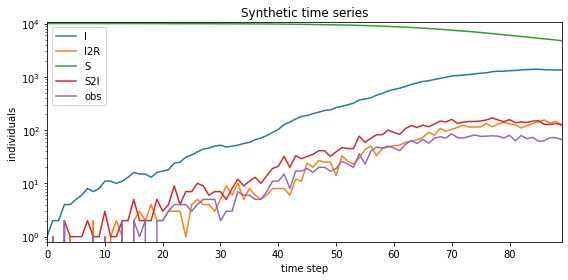

In [20]:
plt.figure(figsize=(8,4))
for name, value in sorted(synth_data.items()):
    if value.dim():
        plt.plot(value, label=name)
plt.xlim(0, len(empty_data) - 1)
plt.ylim(0.8, None)
plt.xlabel("time step")
plt.ylabel("individuals")
plt.yscale("log")
plt.legend(loc="best")
plt.title("Synthetic time series")
plt.tight_layout()

In [22]:
dist.Binomial(3, 0.5.expm1())

AttributeError: ignored

# SIR from scratch

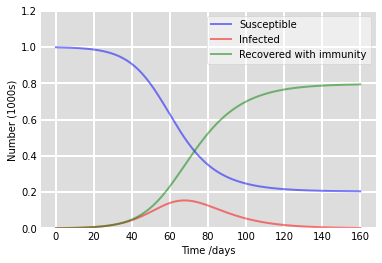

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

# another

In [2]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
  Created wheel for mpld3: filename=mpld3-0.5.5-py3-none-any.whl size=200909 sha256=2512be90b933e4b1a7377324efe7d95a2c3214e51fd91ac6b991f1b4e6ea4e6c
  Stored in directory: /root/.cache/pip/wheels/3b/f3/08/a11447ac4ea31d7603142e76b4cba9e48b2fa7d82b76b69731
Successfully built mpld3


In [3]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [4]:
N = 1000
beta = 1.0  # infected person infects 1 other person per day
D = 4.0 # infections lasts four days
gamma = 1.0 / D

S0, I0, R0 = 999, 1, 0  # initial conditions: one infected, rest susceptible

In [5]:
t = np.linspace(0, 49, 50) # Grid of time points (in days)
y0 = S0, I0, R0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

In [6]:
def plotsir(t, S, I, R):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend()
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  plt.show()

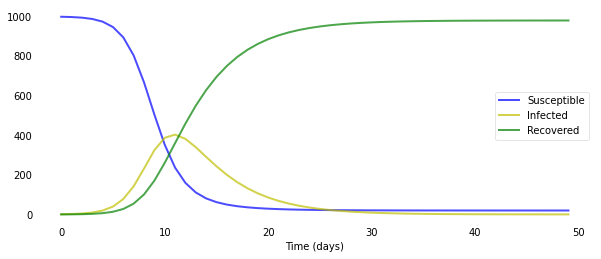

In [7]:
plotsir(t, S, I, R)